# Mediapiple Facemesh + Texture

## references
- https://github.com/google/mediapipe/issues/1698
- https://github.com/google/mediapipe/issues/1798
- https://github.com/google/mediapipe/tree/master/mediapipe/modules/face_geometry/data
- https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
- https://github.com/google/mediapipe/blob/e6c19885c6d3c6f410c730952aeed2852790d306/mediapipe/modules/face_geometry/data/canonical_face_model.obj

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
import plotly.graph_objects as go


def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    return ax

uv_path = "./data/uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

In [38]:
# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def load_obj(obj_filename):
    """ Ref: https://github.com/facebookresearch/pytorch3d/blob/25c065e9dafa90163e7cec873dbb324a637c68b7/pytorch3d/io/obj_io.py
    Load a mesh from a file-like object.
    """
    with open(obj_filename, 'r') as f:
        lines = [line.strip() for line in f]

    verts, uvcoords = [], []
    faces, uv_faces = [], []
    # startswith expects each line to be a string. If the file is read in as
    # bytes then first decode to strings.
    if lines and isinstance(lines[0], bytes):
        lines = [el.decode("utf-8") for el in lines]

    for line in lines:
        tokens = line.strip().split()
        if line.startswith("v "):  # Line is a vertex.
            vert = [float(x) for x in tokens[1:4]]
            if len(vert) != 3:
                msg = "Vertex %s does not have 3 values. Line: %s"
                raise ValueError(msg % (str(vert), str(line)))
            verts.append(vert)
        elif line.startswith("vt "):  # Line is a texture.
            tx = [float(x) for x in tokens[1:3]]
            if len(tx) != 2:
                raise ValueError(
                    "Texture %s does not have 2 values. Line: %s" % (str(tx), str(line))
                )
            uvcoords.append(tx)
        elif line.startswith("f "):  # Line is a face.
            # Update face properties info.
            face = tokens[1:]
            face_list = [f.split("/") for f in face]
            for vert_props in face_list:
                # Vertex index.
                faces.append(int(vert_props[0]))
                if len(vert_props) > 1:
                    if vert_props[1] != "":
                        # Texture index is present e.g. f 4/1/1.
                        uv_faces.append(int(vert_props[1]))

    verts = np.array(verts)
    uvcoords = np.array(uvcoords)
    faces = np.array(faces); faces = faces.reshape(-1, 3) - 1
    uv_faces = np.array(uv_faces); uv_faces = uv_faces.reshape(-1, 3) - 1
    return (
        verts,
        uvcoords,
        faces,
        uv_faces
    )

# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def write_obj(obj_name,
              vertices,
              faces,
              texture_name = "texture.jpg",
              colors=None,
              texture=None,
              uvcoords=None,
              uvfaces=None,
              inverse_face_order=False,
              normal_map=None,
              ):
    ''' Save 3D face model with texture. 
    Ref: https://github.com/patrikhuber/eos/blob/bd00155ebae4b1a13b08bf5a991694d682abbada/include/eos/core/Mesh.hpp
    Args:
        obj_name: str
        vertices: shape = (nver, 3)
        colors: shape = (nver, 3)
        faces: shape = (ntri, 3)
        texture: shape = (uv_size, uv_size, 3)
        uvcoords: shape = (nver, 2) max value<=1
    '''
    if os.path.splitext(obj_name)[-1] != '.obj':
        obj_name = obj_name + '.obj'

    # Get the directory path from the file path
    directory = os.path.dirname(obj_name)
    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    mtl_name = obj_name.replace('.obj', '.mtl')
    texture_name
    material_name = 'FaceTexture'

    faces = faces.copy()
    # mesh lab start with 1, python/c++ start from 0
    faces += 1
    if inverse_face_order:
        faces = faces[:, [2, 1, 0]]
        if uvfaces is not None:
            uvfaces = uvfaces[:, [2, 1, 0]]

    # write obj
    with open(obj_name, 'w') as f:
        # first line: write mtlib(material library)
        # f.write('# %s\n' % os.path.basename(obj_name))
        # f.write('#\n')
        # f.write('\n')
        if texture is not None:
            f.write('mtllib %s\n\n' % os.path.basename(mtl_name))

        # write vertices
        if colors is None:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2]))
        else:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {} {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2], colors[i, 0], colors[i, 1], colors[i, 2]))

        # write uv coords
        if texture is None:
            for i in range(faces.shape[0]):
                f.write('f {} {} {}\n'.format(faces[i, 2], faces[i, 1], faces[i, 0]))
        else:
            for i in range(uvcoords.shape[0]):
                f.write('vt {} {}\n'.format(uvcoords[i,0], uvcoords[i,1]))
            f.write('usemtl %s\n' % material_name)
            # write f: ver ind/ uv ind
            uvfaces = uvfaces + 1
            for i in range(faces.shape[0]):
                f.write('f {}/{} {}/{} {}/{}\n'.format(
                    #  faces[i, 2], uvfaces[i, 2],
                    #  faces[i, 1], uvfaces[i, 1],
                    #  faces[i, 0], uvfaces[i, 0]
                    faces[i, 0], uvfaces[i, 0],
                    faces[i, 1], uvfaces[i, 1],
                    faces[i, 2], uvfaces[i, 2]
                )
                )
            # write mtl
            with open(mtl_name, 'w') as f:
                f.write('newmtl %s\n' % material_name)
                s = 'map_Kd {}\n'.format(os.path.basename(texture_name)) # map to image
                f.write(s)

                if normal_map is not None:
                    name, _ = os.path.splitext(obj_name)
                    normal_name = f'{name}_normals.png'
                    f.write(f'disp {normal_name}')
                    # out_normal_map = normal_map / (np.linalg.norm(
                    #     normal_map, axis=-1, keepdims=True) + 1e-9)
                    # out_normal_map = (out_normal_map + 1) * 0.5

                    cv2.imwrite(
                        normal_name,
                        # (out_normal_map * 255).astype(np.uint8)[:, :, ::-1]
                        normal_map
                    )
            skimage.io.imsave(texture_name, texture)

<Axes: >

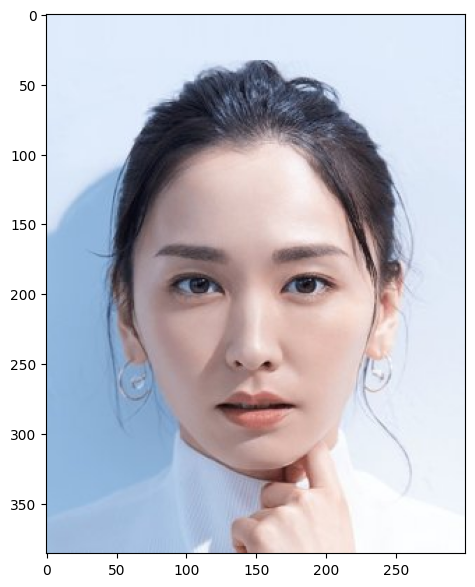

In [22]:
#image source: https://mydramalist.com/people/461-aragaki-yui
img_path = "./data/gakki.jpg"
img_ori = skimage.io.imread(img_path)
imshow(img_ori)

In [23]:
img_ori

array([[[223, 235, 251],
        [223, 235, 251],
        [223, 235, 251],
        ...,
        [224, 236, 252],
        [224, 236, 252],
        [224, 236, 252]],

       [[223, 235, 251],
        [223, 235, 251],
        [223, 235, 251],
        ...,
        [224, 236, 252],
        [224, 236, 252],
        [224, 236, 252]],

       [[223, 235, 251],
        [223, 235, 251],
        [223, 235, 251],
        ...,
        [224, 236, 252],
        [224, 236, 252],
        [224, 236, 252]],

       ...,

       [[161, 190, 222],
        [161, 190, 222],
        [160, 189, 221],
        ...,
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]],

       [[163, 192, 224],
        [161, 190, 222],
        [159, 188, 220],
        ...,
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]],

       [[163, 192, 224],
        [161, 190, 222],
        [159, 188, 220],
        ...,
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]]

In [24]:
img = img_ori
H,W,_ = img.shape
#run facial landmark detection
with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(img)

assert len(results.multi_face_landmarks)==1 

face_landmarks = results.multi_face_landmarks[0]

W0000 00:00:1715403527.876415  223143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1715403527.886164  223142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/nandhika/repositories/public/mediapipe-facemesh/env/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning:

SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.



In [25]:
vertex_positions = np.array([(point.x, point.y, point.z) for point in face_landmarks.landmark[0:468]]) 
texture_coordinates = np.array([(point.x, point.y) for point in face_landmarks.landmark[0:468]]) 

In [26]:
texture_coordinates

array([[0.49606562, 0.70724165],
       [0.49180377, 0.64608508],
       [0.49291664, 0.66275698],
       [0.46977764, 0.57377797],
       [0.49097076, 0.62479794],
       [0.49042302, 0.59541851],
       [0.48960128, 0.52178669],
       [0.31799045, 0.50983369],
       [0.48785952, 0.46621466],
       [0.48692831, 0.43723974],
       [0.48346621, 0.3264111 ],
       [0.49647081, 0.71397531],
       [0.49680889, 0.72073102],
       [0.49722373, 0.72516024],
       [0.49830043, 0.73653895],
       [0.49895966, 0.74601257],
       [0.4995105 , 0.75738657],
       [0.50015372, 0.76867706],
       [0.49969986, 0.78195488],
       [0.49236637, 0.65572733],
       [0.4701702 , 0.65411514],
       [0.21779558, 0.42298007],
       [0.3890174 , 0.53013146],
       [0.36344856, 0.5314365 ],
       [0.33905119, 0.53028101],
       [0.30834579, 0.51793289],
       [0.41069847, 0.52598953],
       [0.34589475, 0.47029427],
       [0.37634474, 0.4726243 ],
       [0.31924343, 0.47430521],
       [0.

In [27]:
# Extract x, y, z coordinates from vertices
x = [vertex[0] for vertex in vertex_positions]
y = [vertex[1] for vertex in vertex_positions]
z = [vertex[2] for vertex in vertex_positions]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=1.5))])

# Customize the layout
fig.update_layout(scene=dict(
                    xaxis_title='X-axis Title',
                    yaxis_title='Y-axis Title',
                    zaxis_title='Z-axis Title'),
                  width=700,
                  margin=dict(r=20, l=10, b=10, t=10))

# Show the plot
fig.show()

In [28]:
import plotly.graph_objects as go

# Sample data
x = [vertex[0] for vertex in texture_coordinates]
y = [vertex[1] for vertex in texture_coordinates]

# Create a line plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers', marker=dict(size=2)))

layout_scale = 1.5

# Customize the layout
fig.update_layout(title='2D Line Plot',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  xaxis=dict(range=[0, 1]),
                  yaxis=dict(range=[0, 1]),
                  width=W * layout_scale,
                  height=H * layout_scale)

# Show the plot
fig.show()

In [29]:
import plotly.graph_objects as go

# Sample data
x = [vertex[0] * W for vertex in texture_coordinates]
y = [vertex[1] * H for vertex in texture_coordinates]

# Create a line plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers', marker=dict(size=2)))

layout_scale = 1.5

# Customize the layout
fig.update_layout(title='2D Line Plot',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  xaxis=dict(range=[0, W]),
                  yaxis=dict(range=[0, H]),
                  width=W * layout_scale,
                  height=H * layout_scale,
                )

# Show the plot
fig.show()

In [30]:
import math


def rotate_array(array, center, angle_degrees):
    # Convert angle from degrees to radians
    angle_rad = math.radians(angle_degrees)
    
    # Define rotation matrix
    rotation_matrix = np.array([[math.cos(angle_rad), -math.sin(angle_rad)],
                                [math.sin(angle_rad), math.cos(angle_rad)]])
    
    # Translate the center to the origin
    translated_array = array - center
    
    # Apply rotation
    rotated_array = np.dot(translated_array, rotation_matrix.T) + center
    
    return rotated_array

In [31]:
new_texture_coordinates = rotate_array(texture_coordinates, np.array([0.5, 0.5]), 180)
new_texture_coordinates

array([[0.50393438, 0.29275835],
       [0.50819623, 0.35391492],
       [0.50708336, 0.33724302],
       [0.53022236, 0.42622203],
       [0.50902924, 0.37520206],
       [0.50957698, 0.40458149],
       [0.51039872, 0.47821331],
       [0.68200955, 0.49016631],
       [0.51214048, 0.53378534],
       [0.51307169, 0.56276026],
       [0.51653379, 0.6735889 ],
       [0.50352919, 0.28602469],
       [0.50319111, 0.27926898],
       [0.50277627, 0.27483976],
       [0.50169957, 0.26346105],
       [0.50104034, 0.25398743],
       [0.5004895 , 0.24261343],
       [0.49984628, 0.23132294],
       [0.50030014, 0.21804512],
       [0.50763363, 0.34427267],
       [0.5298298 , 0.34588486],
       [0.78220442, 0.57701993],
       [0.6109826 , 0.46986854],
       [0.63655144, 0.4685635 ],
       [0.66094881, 0.46971899],
       [0.69165421, 0.48206711],
       [0.58930153, 0.47401047],
       [0.65410525, 0.52970573],
       [0.62365526, 0.5273757 ],
       [0.68075657, 0.52569479],
       [0.

In [32]:
import plotly.graph_objects as go

# Sample data
x = [vertex[0] for vertex in new_texture_coordinates]
y = [vertex[1] for vertex in new_texture_coordinates]

# Create a line plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers', marker=dict(size=2)))

layout_scale = 1.5

# Customize the layout
fig.update_layout(title='2D Line Plot',
                  xaxis_title='X-axis',
                  yaxis_title='Y-axis',
                  xaxis=dict(range=[0, 1]),
                  yaxis=dict(range=[0, 1]),
                  width=W * layout_scale,
                  height=H * layout_scale,
                )

# Show the plot
fig.show()

In [33]:
#https://scikit-image.org/docs/dev/auto_examples/transform/plot_piecewise_affine.html
H_new,W_new = 512,512
keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])

tform = PiecewiseAffineTransform()
tform.estimate(keypoints_uv,keypoints)
texture = warp(img_ori, tform, output_shape=(H_new,W_new))
texture = (255*texture).astype(np.uint8)

ax = imshow(texture)
ax.plot(keypoints_uv[:, 0], keypoints_uv[:, 1], '.b', markersize=2)
plt.show()

NameError: name 'keypoints' is not defined

In [34]:
keypoints3d = np.array([(point.x,point.y,point.z) for point in face_landmarks.landmark[0:468]])

In [35]:
obj_filename = "./data/canonical_face_model.obj"
verts,uvcoords,faces,uv_faces = load_obj(obj_filename)

In [39]:
def normalize_keypoints(keypoints3d):
    center = keypoints3d[0]
    keypoints3d = keypoints3d - center
    axis1 = keypoints3d[165] - keypoints3d[391]
    axis2 = keypoints3d[2] - keypoints3d[0]
    axis3 = np.cross(axis2,axis1)
    axis3 = axis3/np.linalg.norm(axis3)
    axis2 = axis2/np.linalg.norm(axis2)
    axis1 = np.cross(axis3, axis2)
    axis1 = axis1/np.linalg.norm(axis1)
    U = np.array([axis3,axis2,axis1])
    keypoints3d = keypoints3d.dot(U)
    keypoints3d = keypoints3d - keypoints3d.mean(axis=0)
    return keypoints3d

vertices = normalize_keypoints(vertex_positions)

# borrowed from https://github.com/YadiraF/PRNet/blob/master/utils/write.py
obj_name =  "./results/without_piecewise/obj_model.obj"
write_obj(obj_name,
              vertices,
              faces,
              texture_name = "./results/without_piecewise/texture.jpg",
              texture=img_ori,
              uvcoords=new_texture_coordinates,
              uvfaces=uv_faces,
              )